# "A basic Learner"
- categories: [fastpages, jupyter, learner]


## Intro
I have recently started the [fastai course v4](https://course.fast.ai/) after many postponements. Although I have been working with AI for a few years now I always thought Jeremy Howard's approach of teaching it's very interesting and ... different. Learning the _whole game_ from the start it's more appealing than learning what a tensor is. From the very start the course takes you through the whole process of developing an AI model and into deployment. I believe when the first version of the course was published AI was just beginning to be popular and many of the libraries and resources were _not yet invented_. Now they have all these cool tools to present the entire lifecycle while the students can better see the big picture.  This is just a testament of how much the community has evolved and how the _fastai_ team has succesfully managed to keep up the pace.  Thank you! 🙏

fastai through the voice of Rachel Thomas encourages its students to start blogging. Another uncommon idea. What learning deep learning has anything to do with writing? [Here](https://medium.com/@racheltho/why-you-yes-you-should-blog-7d2544ac1045) you can find some good points about why blogging helps. Through this blog post (and maybe others that will follow) I want to test their hypothesis. I just want to try it and see how it goes.

So, without further ado let's get our hands dirty with some deep learning. 

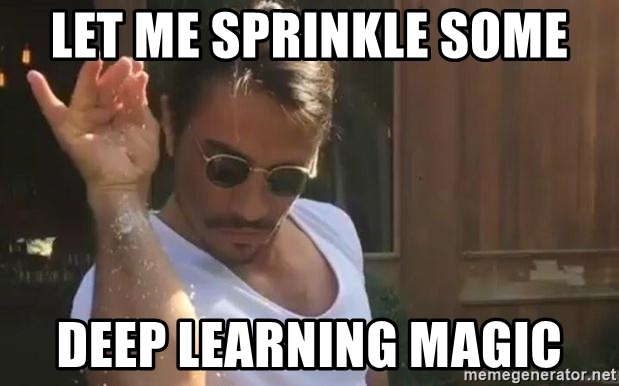

## Write a basic Learner
In this section I'll explain how I created a **_Learner_** from scratch by following the 7 steps for developing any deep learning model. 



1.   Initialize the parameters of the network;
2.   Predict on some input data;
3.   Compute the loss function. In other words how the predictions are different from the target (what we actually want);
4.   Compute the parameters' gradients;
5.   Update the parameters using backpropagation;
6.   Repeat
7.   Stop


For this purpose I'll use the same MNIST_SAMPLE dataset that it's used in the book. It only contains the digits three and seven, so we'll start simple by resolving a binary classification problem. The fastai library provides some useful and easy to understand functions in order to get up and going realy quickly. I will not go into details about them. 


In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *
import pandas as pd

In [3]:
#hide
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train')]

In [4]:
#hide
labels_df = pd.read_csv(path/"labels.csv")
labels_df.head(3)

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0


In [5]:
#hide
(path/"train").ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [6]:
#hide
def load_img(img_path):
  img = Image.open(path/img_path)
  # transform the image into a vector and rescale it to [0, 1]
  img = tensor(img).view(28*28).float()/255 
  return img

train_df = labels_df.loc[labels_df['name'].str.contains('train'), :]
test_df = labels_df.loc[labels_df['name'].str.contains('valid'), :]

train_dst = [(load_img(row['name']), tensor(row['label'])) for _, row in train_df.iterrows()]
test_dst  = [(load_img(row['name']), tensor(row['label'])) for _, row in test_df.iterrows()]

In [7]:
#hide
train_dst[0][0].shape, train_dst[0][1].shape, test_dst[0][0].shape, test_dst[0][1].shape

(torch.Size([784]), torch.Size([]), torch.Size([784]), torch.Size([]))

This is my implementation of a basic Learner that puts together all the necessary "ingredients" in order to train simple neural network:
- `dls`: the data
- `model`: the neural network
- `opt_func`: optimization rule
- `loss_func`: it's used by the model
- `metrics`: the metrics we care about

The function that does all the work is `fit()`. It updates the parameters of the network a number of `epochs` by geting a batch of input - target pairs from the train DataLoader (specified in `dls` parameter). The predictions from each batch are compared with the targets and based on these differences the gradiends are updated with a step set by `lr`. The last for loop it's for validation, where we are intereseted in the model performance on unseen data and its parameters are **not** updated. We're also do some brief logging after each epoch ends.


In [8]:
class BasicLearner:
  __name__ = 'BasicLearner'
  __repr__ = basic_repr('dls,model,opt_func,loss_func,metrics')

  def __init__(self, dls, model, opt_func, loss_func, metrics):
    store_attr('dls,model,opt_func,loss_func,metrics')
  
  def _reset(self):
    self.train_loss = []
    self.val_loss = []

  def fit(self, epochs=10, lr=1e-2):
    opt = self.opt_func(self.model.parameters(), lr=lr)
    self._reset()

    for e in range(epochs):
      batch_train_loss = []
      for x,y in self.dls.train:
        pred = self.model(x)
        loss = self.loss_func(pred, y)
        batch_train_loss.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()
      batch_train_loss = tensor(batch_train_loss)

      batch_val_loss = []
      val_metrics = []
      with torch.no_grad():
        for x,y in self.dls.valid:
          pred = self.model(x)
          loss = self.loss_func(pred, y)
          batch_val_loss.append(loss)
          m = self.metrics(pred, y)
          val_metrics.append(m)

      batch_val_loss = tensor(batch_val_loss)
      val_metrics = tensor(val_metrics)

      self.train_loss.append(batch_train_loss.mean())
      self.val_loss.append(batch_val_loss.mean())

      msg = f"Epoch {e}/{epochs}: " \
        f"Train loss {batch_train_loss.mean():.4f} " \
        f"Valid loss {batch_val_loss.mean():.4f} " \
        f"{self.metrics.__name__} {val_metrics.mean():.2f}"
      print(msg)

In [9]:
#hide
bs = 128
train_dl = DataLoader(train_dst, batch_size=bs)
test_dl = DataLoader(test_dst, batch_size=bs, shuffle=False)
dls = DataLoaders(train_dl, test_dl)

In [10]:
#hide
class Linear:
  __name__ = "Linear"
  __repr__ = basic_repr('size,w,b')

  def __init__(self, size):
    self.w, self.b = self._init_params(size), self._init_params(size[1])
    store_attr('size')

  def _init_params(self, size, std=1.0):  
    return (torch.randn(size, dtype=torch.float32)*std).requires_grad_()

  def __call__(self, x):
    res = x@self.w + self.b

    return res
  
  def get_parameters(self):
    return [self.w, self.b]

class Basic2LayersNet:
  __name__ = "Basic2LayersNet"
  __repr__ = basic_repr('l1_size,l2_size,sigmoid')

  def __init__(self, l1_size, l2_size, sigmoid=True):
    store_attr('l1_size,l2_size,sigmoid')

    self.l1 = Linear(l1_size)
    self.l2 = Linear(l2_size)

    self.sigmoid = sigmoid

  def __call__(self, xb):
    res = self.l1(xb)
    res = res.max(tensor(0.0)) #ReLU 
    res = self.l2(res)

    if sigmoid:
      return res.sigmoid()
    return res
  
  def parameters(self):
    params = []
    params += self.l1.get_parameters()
    params += self.l2.get_parameters()
    for p in params:
      yield p

In [11]:
#hide
class BasicOptim:
  __name__ = "BasicOptim"
  __repr__ = basic_repr('parameters,lr')
  def __init__(self, parameters, lr): self.parameters, self.lr = list(parameters), lr
  
  def step(self, *args, **kwargs):
    for p in self.parameters: p.data -= p.grad * self.lr
  
  def zero_grad(self, *args, **kwargs):
    for p in self.parameters: p.grad = None

In [12]:
#hide
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

def mnist_accuracy(predictions, targets):
    correct = (predictions > 0.5) == targets
    return correct.float().mean()

In [13]:
#hide
basic_net = Basic2LayersNet(l1_size=(28*28, 30), l2_size=(30, 1))
basic_net

Basic2LayersNet(l1_size=(784, 30), l2_size=(30, 1), sigmoid=True)

Let's see how it works on the MNIST_SAMPLE dataset. You can check the implemention of all the parameters given to `BasicLearner` class, on github.
The basic network will train for 20 epochs with a learning rate of 0.1. After just a few epochs the model has over 90% accuracy.

In [15]:
learn = BasicLearner(dls, basic_net, BasicOptim, mnist_loss, mnist_accuracy)
print(learn)

BasicLearner(dls=<fastai.data.core.DataLoaders object at 0x7f2c1c21e1d0>, model=Basic2LayersNet(l1_size=(784, 30), l2_size=(30, 1), sigmoid=True), opt_func=<class '__main__.BasicOptim'>, loss_func=<function mnist_loss at 0x7f2c1c2b9830>, metrics=<function mnist_accuracy at 0x7f2c1c2b95f0>)


In [16]:
learn.fit(20, lr=0.1)

Epoch 0/20: Train loss 0.5973 Valid loss 0.5052 mnist_accuracy 0.50
Epoch 1/20: Train loss 0.5023 Valid loss 0.4883 mnist_accuracy 0.51
Epoch 2/20: Train loss 0.3698 Valid loss 0.4163 mnist_accuracy 0.58
Epoch 3/20: Train loss 0.1523 Valid loss 0.3092 mnist_accuracy 0.69
Epoch 4/20: Train loss 0.1131 Valid loss 0.1632 mnist_accuracy 0.84
Epoch 5/20: Train loss 0.0843 Valid loss 0.1107 mnist_accuracy 0.89
Epoch 6/20: Train loss 0.0750 Valid loss 0.0910 mnist_accuracy 0.91
Epoch 7/20: Train loss 0.0683 Valid loss 0.0794 mnist_accuracy 0.92
Epoch 8/20: Train loss 0.0631 Valid loss 0.0693 mnist_accuracy 0.93
Epoch 9/20: Train loss 0.0590 Valid loss 0.0643 mnist_accuracy 0.94
Epoch 10/20: Train loss 0.0570 Valid loss 0.0602 mnist_accuracy 0.94
Epoch 11/20: Train loss 0.0546 Valid loss 0.0568 mnist_accuracy 0.94
Epoch 12/20: Train loss 0.0513 Valid loss 0.0545 mnist_accuracy 0.94
Epoch 13/20: Train loss 0.0497 Valid loss 0.0524 mnist_accuracy 0.95
Epoch 14/20: Train loss 0.0491 Valid loss 0.